In [1]:
# =========================
# 0) Imports & Reproducible
# =========================
import os, math, random, struct
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import pandas as pd

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =========================
# 1) MNIST IDX Readers
# =========================
def load_images(path):
    with open(path, "rb") as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        images = data.reshape(num, 28, 28).astype("float32") / 255.0
        return np.expand_dims(images, axis=-1)  # (N, 28, 28, 1)

def load_labels(path):
    with open(path, "rb") as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

# ----- 修改为你的文件路径 -----
train_images = load_images("train-images.idx3-ubyte")
train_labels = load_labels("train-labels.idx1-ubyte")
test_images  = load_images("t10k-images.idx3-ubyte")
test_labels  = load_labels("t10k-labels.idx1-ubyte")

print("Train:", train_images.shape, train_labels.shape)
print("Test :", test_images.shape,  test_labels.shape)

Train: (60000, 28, 28, 1) (60000,)
Test : (10000, 28, 28, 1) (10000,)


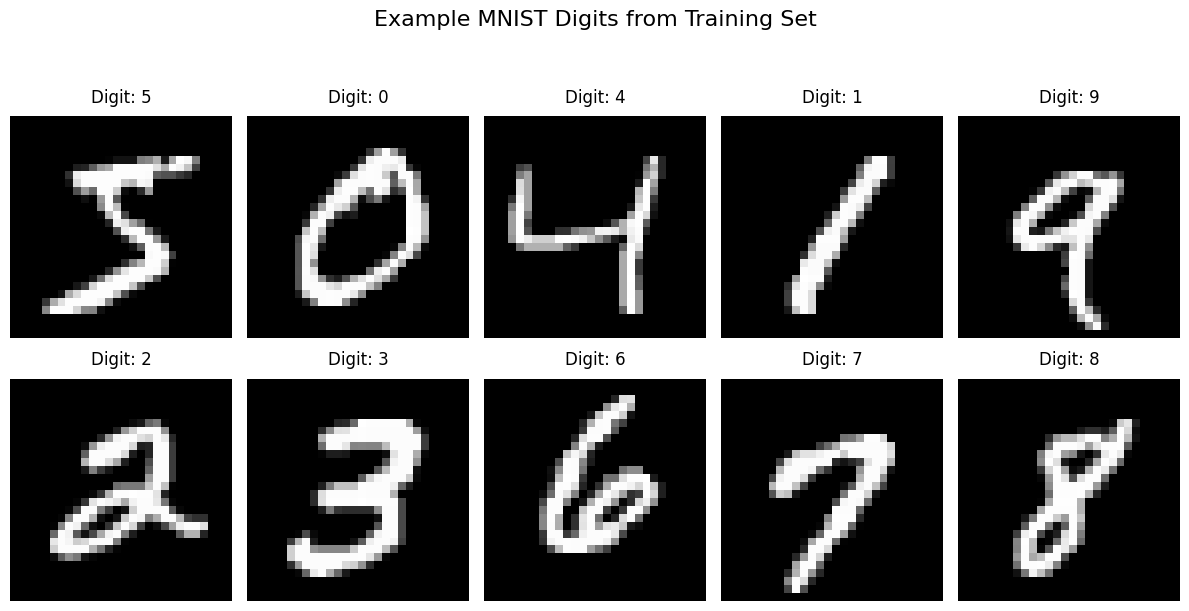

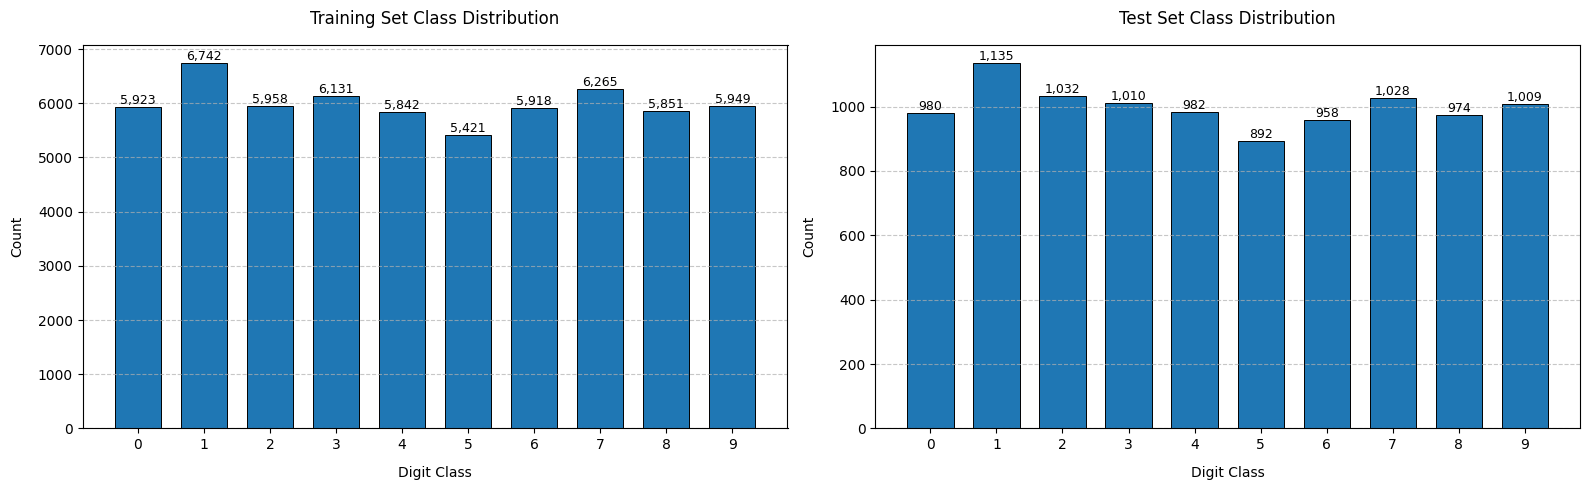


Training Set Statistics:
Total samples: 60,000
Min count: 5,421 (Digit 5)
Max count: 6,742 (Digit 1)

Test Set Statistics:
Total samples: 10,000
Min count: 892 (Digit 5)
Max count: 1,135 (Digit 1)


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 2. 十种数字样本展示
def plot_sample_digits(images, labels, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16, y=1.05)
    
    # 每个数字取第一个出现的样本
    displayed_digits = set()
    plot_idx = 1
    for idx in range(len(labels)):
        digit = labels[idx]
        if digit not in displayed_digits:
            plt.subplot(2, 5, plot_idx)
            plt.imshow(images[idx].squeeze(), cmap='gray')
            plt.title(f"Digit: {digit}", pad=10)
            plt.axis('off')
            displayed_digits.add(digit)
            plot_idx += 1
            if len(displayed_digits) == 10:
                break
    plt.tight_layout()
    plt.show()

# 3. 类别分布条形图
def plot_class_distribution(labels, title, ax=None):
    if ax is None:
        plt.figure(figsize=(10, 5))
        ax = plt.gca()
    
    count = Counter(labels)
    digits = sorted(count.keys())
    counts = [count[d] for d in digits]
    
    bars = ax.bar(digits, counts, width=0.7, edgecolor='black', linewidth=0.7)
    
    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}',
                ha='center', va='bottom', fontsize=9)
    
    ax.set_title(title, pad=15)
    ax.set_xlabel('Digit Class', labelpad=10)
    ax.set_ylabel('Count', labelpad=10)
    ax.set_xticks(digits)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# 4. 执行可视化
# 展示训练集前10个数字样本
plot_sample_digits(train_images, train_labels, "Example MNIST Digits from Training Set")

# 创建并排的分布图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
plot_class_distribution(train_labels, "Training Set Class Distribution", ax1)
plot_class_distribution(test_labels, "Test Set Class Distribution", ax2)
plt.tight_layout()
plt.show()

# 打印统计信息
print("\nTraining Set Statistics:")
print(f"Total samples: {len(train_labels):,}")
print(f"Min count: {min(Counter(train_labels).values()):,} (Digit {min(Counter(train_labels), key=Counter(train_labels).get)})")
print(f"Max count: {max(Counter(train_labels).values()):,} (Digit {max(Counter(train_labels), key=Counter(train_labels).get)})")

print("\nTest Set Statistics:")
print(f"Total samples: {len(test_labels):,}")
print(f"Min count: {min(Counter(test_labels).values()):,} (Digit {min(Counter(test_labels), key=Counter(test_labels).get)})")
print(f"Max count: {max(Counter(test_labels).values()):,} (Digit {max(Counter(test_labels), key=Counter(test_labels).get)})")

In [3]:
# =========================
# 2) Imbalanced dataset maker (3 schemes)
# =========================
def create_imbalanced_dataset(images, labels,
                              mode="scheme1",
                              imbalance_factor=1000,
                              tail_k=3,
                              seed=42,
                              tail_keep_min=0,      # 默认不做尾类补齐
                              tail_aug=False):      # 默认不做增强
    rng = np.random.RandomState(seed)
    classes = np.unique(labels)
    C = len(classes)
    eps = 1e-12

    # --- compute retain_ratio for each class ---
    if mode == "scheme1":
        base = {0:0.05, 1:0.10, 2:0.15, 3:0.20, 4:0.25,
                5:0.30, 6:0.40, 7:0.60, 8:0.80, 9:1.00}
        r_min = min(base.values())
        alpha = np.log(1.0/max(imbalance_factor,1)) / np.log(r_min+eps)
        retain_ratio = {int(c): max(1.0/imbalance_factor, min(1.0, (base[int(c)]**alpha)))
                        for c in classes}

    elif mode == "scheme2":
        retain_ratio = {int(c): 1.0 for c in classes}
        ordered = sorted(classes)
        tail = ordered[:tail_k]
        mid  = ordered[tail_k:tail_k+3]
        for c in tail:
            retain_ratio[int(c)] = 1.0/max(imbalance_factor,1)
        mid_ratio = 1.0/np.sqrt(max(imbalance_factor,1.0))
        for c in mid:
            retain_ratio[int(c)] = mid_ratio

    elif mode == "scheme3":
        retain_ratio = {}
        for rank, c in enumerate(sorted(classes)):
            r = (max(imbalance_factor,1.0) ** (- rank / max(C-1,1)))
            retain_ratio[int(c)] = max(1.0/imbalance_factor, min(1.0, r))
    else:
        retain_ratio = {int(c): 1.0 for c in classes}  # safe default

    # --- sample by ratio (keep >=1) ---
    keep_idx_all = []
    for c in classes:
        idx_c = np.where(labels == c)[0]
        r = float(retain_ratio.get(int(c), 1.0))
        keep = int(len(idx_c) * r + 1e-9)
        keep = min(max(keep, 1), len(idx_c))
        choose = rng.choice(idx_c, size=keep, replace=False)
        keep_idx_all.extend(choose)

    keep_idx_all = np.array(keep_idx_all, dtype=np.int64)
    imgs = images[keep_idx_all]
    lbls = labels[keep_idx_all]

    # --- optional tail completion/augmentation ---
    if tail_keep_min > 0:
        cur_counts = {int(c): np.sum(lbls == c) for c in classes}
        tail_classes = sorted(cur_counts, key=cur_counts.get)[:min(tail_k, len(classes))]
        extra_imgs, extra_lbls = [], []
        for c in tail_classes:
            idx_c = np.where(lbls == c)[0]
            need = max(0, tail_keep_min - len(idx_c))
            if need <= 0: 
                continue
            chosen = np.random.choice(idx_c, size=need, replace=True)
            to_add = imgs[chosen].copy()
            if tail_aug:
                for i in range(to_add.shape[0]):
                    dx = np.random.randint(-2, 3)
                    dy = np.random.randint(-2, 3)
                    im = to_add[i, ..., 0]
                    im = np.roll(im, shift=dx, axis=0)
                    im = np.roll(im, shift=dy, axis=1)
                    im = np.clip(im + np.random.normal(0, 0.02, im.shape), 0.0, 1.0)
                    to_add[i, ..., 0] = im
            extra_imgs.append(to_add)
            extra_lbls.append(np.full((need,), c, dtype=lbls.dtype))
        if extra_imgs:
            imgs = np.concatenate([imgs] + extra_imgs, axis=0)
            lbls = np.concatenate([lbls] + extra_lbls, axis=0)

    return imgs, lbls


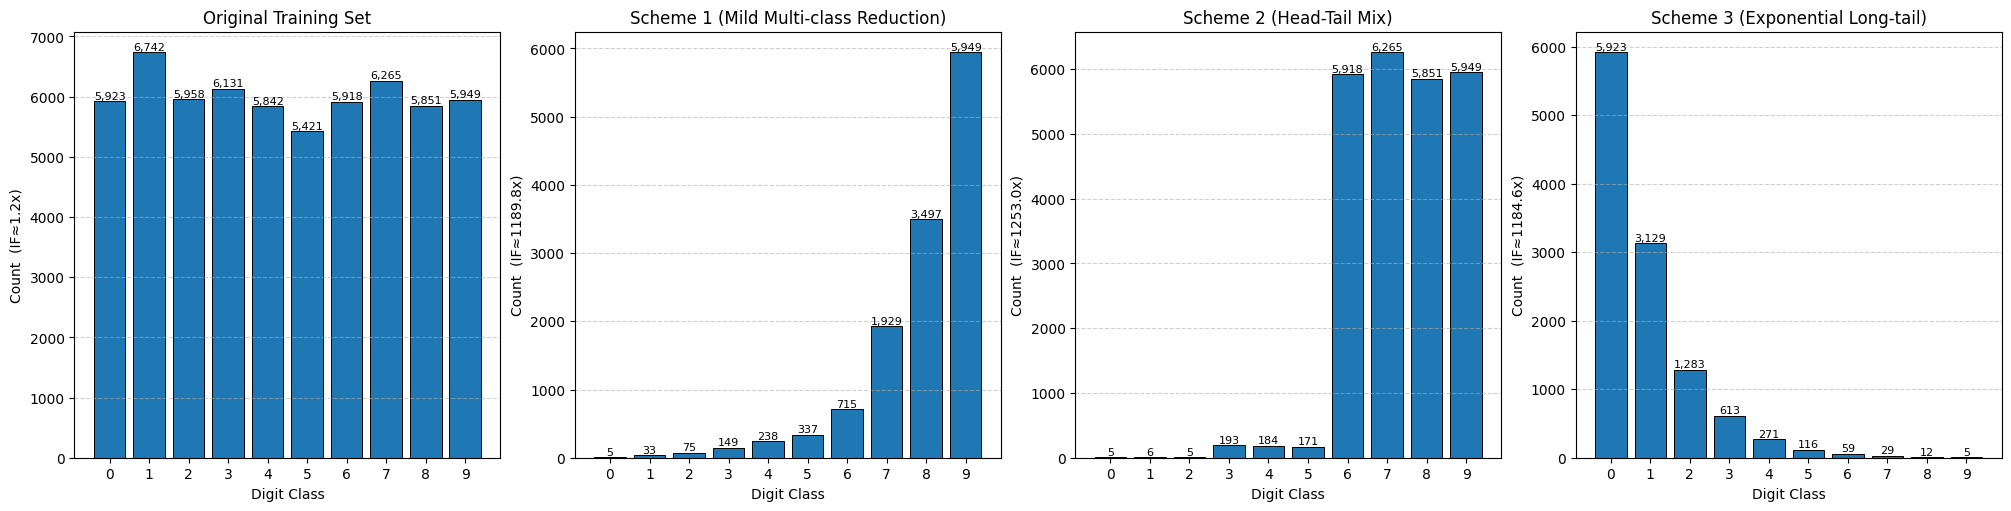


[Original] total=60,000, IF≈1.2x
  class 0: 5,923
  class 1: 6,742
  class 2: 5,958
  class 3: 6,131
  class 4: 5,842
  class 5: 5,421
  class 6: 5,918
  class 7: 6,265
  class 8: 5,851
  class 9: 5,949

[Scheme1] total=12,927, IF≈1189.8x
  class 0: 5
  class 1: 33
  class 2: 75
  class 3: 149
  class 4: 238
  class 5: 337
  class 6: 715
  class 7: 1,929
  class 8: 3,497
  class 9: 5,949

[Scheme2] total=24,547, IF≈1253.0x
  class 0: 5
  class 1: 6
  class 2: 5
  class 3: 193
  class 4: 184
  class 5: 171
  class 6: 5,918
  class 7: 6,265
  class 8: 5,851
  class 9: 5,949

[Scheme3] total=11,440, IF≈1184.6x
  class 0: 5,923
  class 1: 3,129
  class 2: 1,283
  class 3: 613
  class 4: 271
  class 5: 116
  class 6: 59
  class 7: 29
  class 8: 12
  class 9: 5


In [4]:
# ===== 可视化：原始 vs 三种不平衡训练集的类别分布 =====
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# 如果你已经在别处设置了随机种子，可忽略这句
np.random.seed(42)

def plot_dist(ax, labels, title):
    cnt = Counter(labels)
    classes = list(range(10))
    counts = [cnt.get(c, 0) for c in classes]
    bars = ax.bar(classes, counts, edgecolor='black', linewidth=0.7)
    for b, v in zip(bars, counts):
        ax.text(b.get_x()+b.get_width()/2, v, f"{v:,}", ha="center", va="bottom", fontsize=8)
    ax.set_title(title)
    ax.set_xlabel("Digit Class")
    ax.set_xticks(classes)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    # 简单定义不平衡因子：max/min
    min_c = max(min(counts), 1)  # 安全避免除零
    max_c = max(counts)
    ax.set_ylabel(f"Count  (IF≈{max_c/min_c:.1f}x)")

# 1) 原始训练集
orig_labels = train_labels  # 已有

# 2) 三种不平衡训练集（与你实验设置一致）
datasets_imb = {}
for mode in ["scheme1", "scheme2", "scheme3"]:
    imgs_i, labels_i = create_imbalanced_dataset(
        train_images, train_labels,
        mode=mode, imbalance_factor=1000, tail_k=3, seed=42
    )
    datasets_imb[mode] = (imgs_i, labels_i)

# 3) 画图：原始 + 三种不平衡
fig, axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)
plot_dist(axes[0], orig_labels, "Original Training Set")
plot_dist(axes[1], datasets_imb["scheme1"][1], "Scheme 1 (Mild Multi-class Reduction)")
plot_dist(axes[2], datasets_imb["scheme2"][1], "Scheme 2 (Head-Tail Mix)")
plot_dist(axes[3], datasets_imb["scheme3"][1], "Scheme 3 (Exponential Long-tail)")
plt.show()

# 4) 也打印数值统计，便于记录
def print_stats(name, labels):
    cnt = Counter(labels)
    classes = list(range(10))
    counts = np.array([cnt.get(c, 0) for c in classes])
    max_c, min_c = counts.max(), max(counts.min(), 1)
    print(f"\n[{name}] total={counts.sum():,}, IF≈{max_c/min_c:.1f}x")
    for c in classes:
        print(f"  class {c}: {cnt.get(c,0):,}")

print_stats("Original", orig_labels)
print_stats("Scheme1", datasets_imb["scheme1"][1])
print_stats("Scheme2", datasets_imb["scheme2"][1])
print_stats("Scheme3", datasets_imb["scheme3"][1])


In [5]:
# =========================
# 3) Class weights & FocalLoss
# =========================
def get_class_weights(labels, strategy="uniform", beta=0.99, device="cpu"):
    # 10 类权重（对缺失类做最小计数1，避免除0）
    counts = np.array([max(np.sum(labels == c), 1) for c in range(10)], dtype=np.float32)

    if strategy == "uniform":
        w = np.ones(10, dtype=np.float32)
    elif strategy == "normalized":
        w = 1.0 / counts
        w = w / w.sum() * 10
    elif strategy == "sqrt":
        w = 1.0 / np.sqrt(counts)
        w = w / w.sum() * 10
    elif strategy == "effective":
        w = (1 - beta) / (1 - np.power(beta, counts))
        w = w / w.sum() * 10
    else:
        raise ValueError(f"Unknown class weight strategy: {strategy}")

    return torch.tensor(w, dtype=torch.float32, device=device)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, logits, targets):
        if self.weight is not None and self.weight.device != logits.device:
            self.weight = self.weight.to(logits.device)
        ce = F.cross_entropy(logits, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce)
        loss = (1 - pt) ** self.gamma * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

In [6]:
# =========================
# 4) Keras baseline CNN (PyTorch)
# =========================
class KerasBaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 0)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 0)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # 28->26->13->11->5
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)); x = self.pool1(x)
        x = F.relu(self.conv2(x)); x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)); x = self.dropout(x)
        return self.fc2(x)

In [7]:
# =========================
# 5) Single experiment runner
# =========================
def run_experiment(train_images, train_labels, test_images, test_labels,
                   *, imbalance_mode, loss_type, weight_strategy=None, gamma=None,
                   imbalance_factor=1000, tail_k=3,
                   batch_size=128, epochs=10, lr=1e-3, device=DEVICE):

    # make imbalanced train set
    trX, trY = create_imbalanced_dataset(
        train_images, train_labels,
        mode=imbalance_mode, imbalance_factor=imbalance_factor, tail_k=tail_k, seed=SEED
    )

    # tensors & loaders
    X_train = torch.tensor(trX.transpose(0, 3, 1, 2), dtype=torch.float32)
    y_train = torch.tensor(trY, dtype=torch.long)
    X_test  = torch.tensor(test_images.transpose(0, 3, 1, 2), dtype=torch.float32)
    y_test  = torch.tensor(test_labels, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=batch_size, shuffle=False)

    # model
    model = KerasBaselineCNN().to(device)

    # loss
    class_weights = None
    if weight_strategy:
        class_weights = get_class_weights(trY, strategy=weight_strategy, device=device)

    if loss_type == "CE":
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    elif loss_type == "Focal":
        criterion = FocalLoss(gamma=gamma if gamma is not None else 2.0, weight=class_weights)
    else:
        raise ValueError("Unknown loss type")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # train
    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

    # eval
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).argmax(dim=1).cpu().numpy()
            all_preds.extend(pred)
            all_labels.extend(yb.numpy())

    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    per_class_f1 = f1_score(all_labels, all_preds, average=None, labels=list(range(10)))
    # tail classes defined by training distribution
    train_counts = np.array([np.sum(trY == c) for c in range(10)])
    tail_classes = np.argsort(train_counts)[:tail_k]
    tail_macro_f1 = per_class_f1[tail_classes].mean()

    return macro_f1, tail_macro_f1


In [8]:
# =========================
# 6) Build 21 experiments
# =========================
experiments = []
modes = ["scheme1", "scheme2", "scheme3"]

# 1) CE (no weight) -> 3
for m in modes:
    experiments.append((m, "CE", None, None))

# 2) CE (+ normalized/sqrt/effective) -> 9
for m in modes:
    for w in ["normalized", "sqrt", "effective"]:
        experiments.append((m, "CE", w, None))

# 3) Focal (+ effective weight, gamma in {1,2,3}) -> 9
for m in modes:
    for g in [1, 2, 3]:
        experiments.append((m, "Focal", "effective", g))

assert len(experiments) == 21


In [9]:
# =========================
# 7) Run & Report
# =========================
results = []
for mode, loss_type, weight_strategy, gamma in experiments:
    macro_f1, tail_macro_f1 = run_experiment(
        train_images, train_labels, test_images, test_labels,
        imbalance_mode=mode,
        loss_type=loss_type,
        weight_strategy=weight_strategy,
        gamma=gamma,
        imbalance_factor=1000,   # 你当前设定
        tail_k=3,
        batch_size=128, epochs=10, lr=1e-3, device=DEVICE
    )
    print(f"[EXP] mode={mode:7s} | loss={loss_type:5s} | weight={str(weight_strategy):10s} "
          f"| gamma={str(gamma):>4s} | Macro-F1={macro_f1:.4f} | Tail-Macro-F1={tail_macro_f1:.4f}")

    results.append({
        "mode": mode,
        "loss_type": loss_type,
        "weight_strategy": weight_strategy,
        "gamma": gamma,
        "macro_f1": macro_f1,
        "tail_macro_f1": tail_macro_f1
    })

df_results = pd.DataFrame(results)
print("\n=== Summary (21 runs) ===")
print(df_results)

[EXP] mode=scheme1 | loss=CE    | weight=None       | gamma=None | Macro-F1=0.8004 | Tail-Macro-F1=0.5954
[EXP] mode=scheme2 | loss=CE    | weight=None       | gamma=None | Macro-F1=0.6416 | Tail-Macro-F1=0.2054
[EXP] mode=scheme3 | loss=CE    | weight=None       | gamma=None | Macro-F1=0.7152 | Tail-Macro-F1=0.3736
[EXP] mode=scheme1 | loss=CE    | weight=normalized | gamma=None | Macro-F1=0.9569 | Tail-Macro-F1=0.9480
[EXP] mode=scheme1 | loss=CE    | weight=sqrt       | gamma=None | Macro-F1=0.9419 | Tail-Macro-F1=0.9041
[EXP] mode=scheme1 | loss=CE    | weight=effective  | gamma=None | Macro-F1=0.8962 | Tail-Macro-F1=0.8590
[EXP] mode=scheme2 | loss=CE    | weight=normalized | gamma=None | Macro-F1=0.8836 | Tail-Macro-F1=0.8096
[EXP] mode=scheme2 | loss=CE    | weight=sqrt       | gamma=None | Macro-F1=0.8694 | Tail-Macro-F1=0.7708
[EXP] mode=scheme2 | loss=CE    | weight=effective  | gamma=None | Macro-F1=0.8566 | Tail-Macro-F1=0.7714
[EXP] mode=scheme3 | loss=CE    | weight=norma

In [11]:
new_rows = []
modes = ["scheme1", "scheme2", "scheme3"]

# ---- LDAM Loss with DRW ----
class LDAMLoss(nn.Module):
    def __init__(self, class_counts, m_max=0.5, s=30.0, weight=None):
        super().__init__()
        cls = np.asarray(class_counts, dtype=np.float32)
        cls = np.clip(cls, 1.0, None)
        m_list = m_max / np.power(cls, 0.25)   # n^{-1/4}
        self.register_buffer("m_list", torch.tensor(m_list, dtype=torch.float32))
        self.s = s
        self.weight = weight
    def forward(self, logits, targets):
        margins = self.m_list[targets]                   # (B,)
        one_hot = F.one_hot(targets, num_classes=logits.size(1)).float()
        logits_m = logits - one_hot * margins.unsqueeze(1)
        return F.cross_entropy(self.s * logits_m, targets, weight=self.weight)

def run_ldam_drw(mode, imbalance_factor=1000, tail_k=3,
                 batch_size=128, epochs=20, lr=1e-3,
                 drw_start=None, weight_strategy_after="effective",
                 device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    drw_start = drw_start if drw_start is not None else epochs // 2

    # 1) 不平衡训练集
    trX, trY = create_imbalanced_dataset(train_images, train_labels,
                                         mode=mode, imbalance_factor=imbalance_factor,
                                         tail_k=tail_k, seed=42)
    X_train = torch.tensor(trX.transpose(0,3,1,2), dtype=torch.float32)
    y_train = torch.tensor(trY, dtype=torch.long)
    X_test  = torch.tensor(test_images.transpose(0,3,1,2), dtype=torch.float32)
    y_test  = torch.tensor(test_labels, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=batch_size, shuffle=False)

    # 2) 模型与 LDAM（初期不加权）
    model = KerasBaselineCNN().to(device)
    counts = np.array([np.sum(trY == c) for c in range(10)], dtype=np.float32)
    criterion = LDAMLoss(counts, m_max=0.5, s=30.0, weight=None)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # 3) 训练（DRW：后半程再加权）
    for ep in range(epochs):
        if ep == drw_start:
            w = get_class_weights(trY, strategy=weight_strategy_after, device=device)
            criterion = LDAMLoss(counts, m_max=0.5, s=30.0, weight=w)

        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optim.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optim.step()

    # 4) 评估
    model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.extend(model(xb).argmax(1).cpu().numpy())
            gts.extend(yb.numpy())

    macro_f1 = f1_score(gts, preds, average='macro')
    per_cls  = f1_score(gts, preds, average=None, labels=list(range(10)))
    tr_counts = np.array([np.sum(trY == c) for c in range(10)])
    tail_classes = np.argsort(tr_counts)[:tail_k]
    tail_macro_f1 = per_cls[tail_classes].mean()
    return macro_f1, tail_macro_f1

# B. LDAM-DRW（后半程加权）
for m in modes:
    mf1, tf1 = run_ldam_drw(m, imbalance_factor=1000, tail_k=3, epochs=20, drw_start=10,
                            weight_strategy_after="effective")
    print(f"[LDAM-DRW] {m}: Macro-F1={mf1:.4f}, Tail-Macro-F1={tf1:.4f}")
    new_rows.append({"method":"LDAM-DRW", "mode":m, "macro_f1":mf1, "tail_macro_f1":tf1})



[LDAM-DRW] scheme1: Macro-F1=0.9288, Tail-Macro-F1=0.8941
[LDAM-DRW] scheme2: Macro-F1=0.8742, Tail-Macro-F1=0.7809
[LDAM-DRW] scheme3: Macro-F1=0.9089, Tail-Macro-F1=0.8390


In [12]:
from torch.utils.data import WeightedRandomSampler

def _make_cb_sampler_local(labels_np: np.ndarray) -> WeightedRandomSampler:
    classes, counts = np.unique(labels_np, return_counts=True)
    w_per_class = {int(c): 1.0 / cnt for c, cnt in zip(classes, counts)}
    sample_w = np.array([w_per_class[int(y)] for y in labels_np], dtype=np.float32)
    return WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)

def run_cb_tailaug(mode, imbalance_factor=1000, tail_k=3,
                   tail_keep_min=200, tail_aug=True,
                   batch_size=128, epochs=10, lr=1e-3, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # 1) 不平衡 + 尾类补齐/增强
    trX, trY = create_imbalanced_dataset(train_images, train_labels,
                                         mode=mode, imbalance_factor=imbalance_factor,
                                         tail_k=tail_k, seed=42,
                                         tail_keep_min=tail_keep_min, tail_aug=tail_aug)
    X_train = torch.tensor(trX.transpose(0,3,1,2), dtype=torch.float32)
    y_train = torch.tensor(trY, dtype=torch.long)
    X_test  = torch.tensor(test_images.transpose(0,3,1,2), dtype=torch.float32)
    y_test  = torch.tensor(test_labels, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train, y_train),
                              batch_size=batch_size,
                              sampler=_make_cb_sampler_local(trY),
                              shuffle=False)
    test_loader  = DataLoader(TensorDataset(X_test,  y_test),
                              batch_size=batch_size, shuffle=False)

    # 2) 模型与标准 CE
    model = KerasBaselineCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # 3) 训练
    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optim.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optim.step()

    # 4) 评估
    model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds.extend(model(xb).argmax(1).cpu().numpy())
            gts.extend(yb.numpy())

    macro_f1 = f1_score(gts, preds, average='macro')
    per_cls  = f1_score(gts, preds, average=None, labels=list(range(10)))
    tr_counts = np.array([np.sum(trY == c) for c in range(10)])
    tail_classes = np.argsort(tr_counts)[:tail_k]
    tail_macro_f1 = per_cls[tail_classes].mean()
    return macro_f1, tail_macro_f1

# C. 仅尾类补齐/增强 + 类均衡采样
for m in modes:
    mf1, tf1 = run_cb_tailaug(m, imbalance_factor=1000, tail_k=3,
                              tail_keep_min=200, tail_aug=True, epochs=10)
    print(f"[CB+TailAug] {m}: Macro-F1={mf1:.4f}, Tail-Macro-F1={tf1:.4f}")
    new_rows.append({"method":"CB+TailAug", "mode":m, "macro_f1":mf1, "tail_macro_f1":tf1})

[CB+TailAug] scheme1: Macro-F1=0.9703, Tail-Macro-F1=0.9702
[CB+TailAug] scheme2: Macro-F1=0.9475, Tail-Macro-F1=0.9702
[CB+TailAug] scheme3: Macro-F1=0.9354, Tail-Macro-F1=0.9532


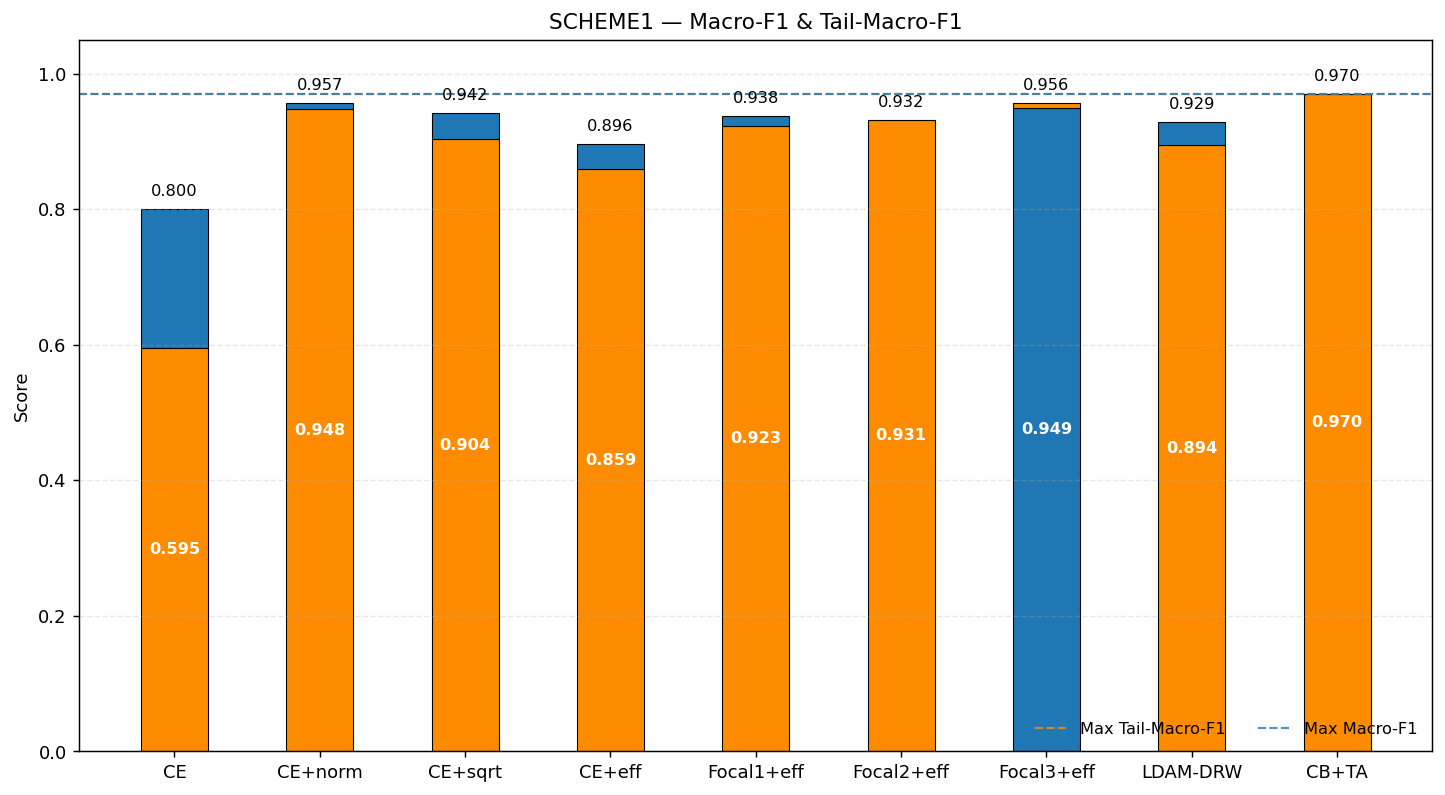

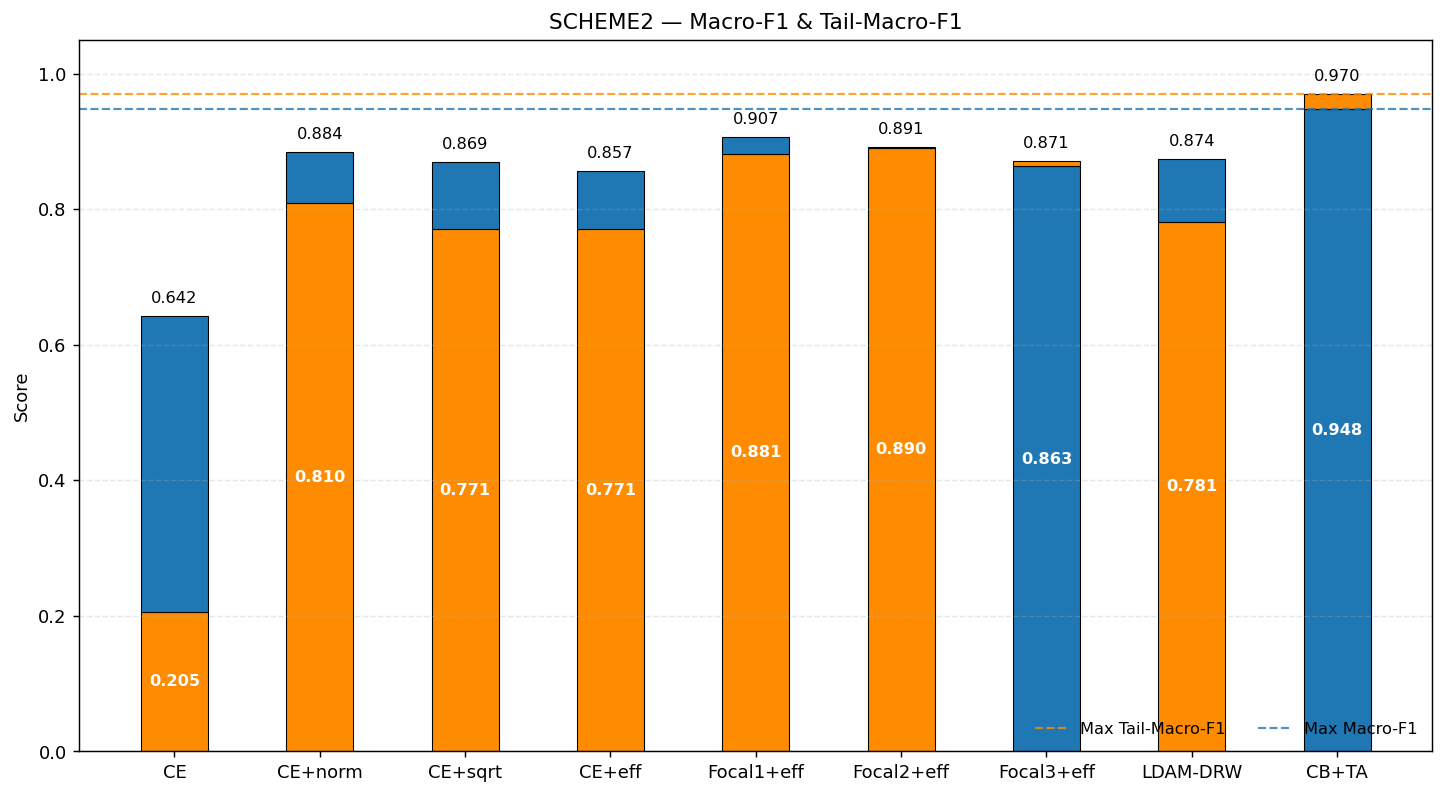

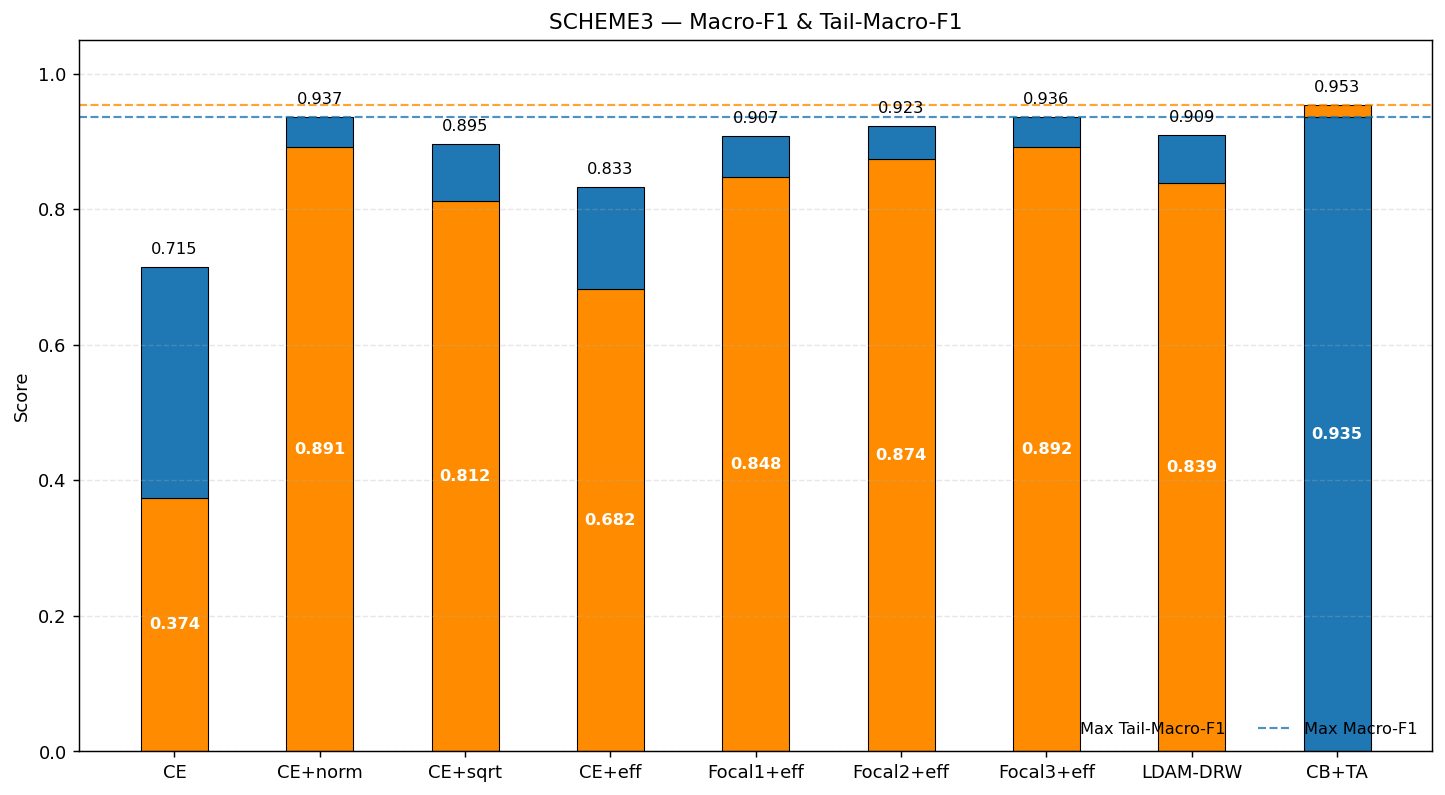

In [20]:
import numpy as np
import matplotlib.pyplot as plt

abbr_map = {
    "CE": "CE",
    "CE+normalized": "CE+norm",
    "CE+sqrt": "CE+sqrt",
    "CE+effective": "CE+eff",
    "Focal γ=1 + effective": "Focal1+eff",
    "Focal γ=2 + effective": "Focal2+eff",
    "Focal γ=3 + effective": "Focal3+eff",
    "LDAM-DRW": "LDAM-DRW",
    "CB+TailAug": "CB+TA",
}

methods_in_plot = [m for m in abbr_map if (m in pt_macro.columns) and (m in pt_tail.columns)]

for scheme in pt_macro.index:
    macro_vals, tail_vals, labels = [], [], []
    for m in methods_in_plot:
        mac = pt_macro.loc[scheme, m]
        tai = pt_tail.loc[scheme, m]
        if not (np.isnan(mac) or np.isnan(tai)):
            macro_vals.append(float(mac))
            tail_vals.append(float(tai))
            labels.append(abbr_map.get(m, m))
    macro_vals = np.array(macro_vals)
    tail_vals  = np.array(tail_vals)

    n = len(labels)
    gap = 1.3
    x = np.arange(n) * gap
    width = 0.6

    fig, ax = plt.subplots(figsize=(11, 6), dpi=130, constrained_layout=True)

    for xi, label, mac, tai in zip(x, labels, macro_vals, tail_vals):
        if tai <= mac:
            # 先画 Tail（下），再画 Macro-Tail（上）
            ax.bar(xi, tai, width=width, color="#ff8c00", edgecolor="black", linewidth=0.6)
            ax.bar(xi, mac - tai, width=width, bottom=tai, color="#1f77b4", edgecolor="black", linewidth=0.6)
            ax.text(xi, tai * 0.5, f"{tai:.3f}", ha="center", va="center", fontsize=9, color="white", fontweight="bold")
            ax.text(xi, mac + 0.015, f"{mac:.3f}", ha="center", va="bottom", fontsize=9)
        else:
            # Tail > Macro，先画 Macro（下），再画 Tail-Macro（上）
            ax.bar(xi, mac, width=width, color="#1f77b4", edgecolor="black", linewidth=0.6)
            ax.bar(xi, tai - mac, width=width, bottom=mac, color="#ff8c00", edgecolor="black", linewidth=0.6)
            ax.text(xi, mac * 0.5, f"{mac:.3f}", ha="center", va="center", fontsize=9, color="white", fontweight="bold")
            ax.text(xi, tai + 0.015, f"{tai:.3f}", ha="center", va="bottom", fontsize=9)

    # 虚线
    max_macro = float(np.max(macro_vals))
    max_tail  = float(np.max(tail_vals))
    ax.axhline(max_tail, linestyle="--", linewidth=1.2, color="#ff8c00", alpha=0.8, label="Max Tail-Macro-F1")
    ax.axhline(max_macro, linestyle="--", linewidth=1.2, color="#1f77b4", alpha=0.8, label="Max Macro-F1")

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0)
    ax.set_ylim(0.0, 1.05)
    ax.set_ylabel("Score")
    ax.set_title(f"{scheme.upper()} — Macro-F1 & Tail-Macro-F1")
    ax.grid(axis="y", linestyle="--", alpha=0.3)

    handles, leglabels = ax.get_legend_handles_labels()
    uniq = dict(zip(leglabels, handles))
    ax.legend(uniq.values(), uniq.keys(), frameon=False, ncol=2, fontsize=9, loc="lower right")

    plt.show()


In [26]:
# =========================
# 导出 Excel（每个场景一个工作表，方法名用简写）
# 依赖：df_results（前21次实验 DataFrame），new_rows（LDAM-DRW & CB+TailAug 结果列表）
# =========================
import os
import sys
import pandas as pd

# 1) 把 21 次实验的方法名转成简写
def _abbr_method_from_row(row: pd.Series) -> str:
    lt = str(row["loss_type"])
    ws = None if pd.isna(row.get("weight_strategy")) else str(row["weight_strategy"])
    gm = None if pd.isna(row.get("gamma")) else int(row["gamma"])
    if lt == "CE" and (ws is None or ws == "None"):
        return "CE"
    if lt == "CE" and ws in {"normalized", "sqrt", "effective"}:
        mapping = {"normalized": "norm", "sqrt": "sqrt", "effective": "eff"}
        return f"CE+{mapping[ws]}"
    if lt == "Focal":
        g = 2 if gm is None else gm
        return f"Focal γ={g}+eff"
    # 兜底
    return lt

df21 = df_results.copy()
df21["method"] = df21.apply(_abbr_method_from_row, axis=1)
df21 = df21[["mode", "method", "macro_f1", "tail_macro_f1"]]

# 2) 把新增方法（LDAM-DRW, CB+TailAug）也转成简写
df_extra = pd.DataFrame(new_rows) if len(new_rows) > 0 else pd.DataFrame(columns=["method","mode","macro_f1","tail_macro_f1"])
if not df_extra.empty:
    df_extra = df_extra.rename(columns={"tail_macro_f1":"tail_macro_f1", "macro_f1":"macro_f1"})
    # 简写映射
    df_extra = df_extra.assign(
        method=df_extra["method"].replace({
            "LDAM-DRW": "LDAM-DRW",
            "CB+TailAug": "CB+TA"
        })
    )
    df_extra = df_extra[["mode","method","macro_f1","tail_macro_f1"]]

# 3) 合并 & 去重（如果同一方法/场景有多行，保留分数最高的一行）
df_all = pd.concat([df21, df_extra], ignore_index=True)

# 统一排序顺序（不存在的会自动忽略）
method_order = [
    "CE",
    "CE+norm", "CE+sqrt", "CE+eff",
    "Focal γ=1+eff", "Focal γ=2+eff", "Focal γ=3+eff",
    "LDAM-DRW",
    "CB+TA",
]
mode_order = ["scheme1", "scheme2", "scheme3"]

# 去重：同一 (mode, method) 取 Macro-F1 更高者
df_all = (df_all
          .sort_values(["mode","method","macro_f1"], ascending=[True, True, False])
          .drop_duplicates(subset=["mode","method"], keep="first")
          .reset_index(drop=True))

# 4) 写入 Excel：每个场景一个 sheet，并加排名列
out_path = "mnist_imbalance_results.xlsx"

# 优先用 openpyxl 引擎；没有则让 pandas 自选（通常会写 CSV 兼容引擎）
try:
    writer = pd.ExcelWriter(out_path, engine="openpyxl")
except Exception:
    writer = pd.ExcelWriter(out_path)

with writer as w:
    for md in mode_order:
        sub = df_all[df_all["mode"] == md].copy()
        if sub.empty:
            # 如果该场景没有数据，也写一张空表，列名齐全
            sub = pd.DataFrame(columns=["mode","method","macro_f1","tail_macro_f1","rank_macro","rank_tail"])
        else:
            # 排序：先按我们定义的方法顺序，再按 Macro-F1 降序
            sub["__morder"] = sub["method"].map({m:i for i,m in enumerate(method_order)})
            sub["__morder"] = sub["__morder"].fillna(999)
            sub = sub.sort_values(["__morder","macro_f1"], ascending=[True, False]).drop(columns="__morder")

            # 添加排名
            sub["rank_macro"] = sub["macro_f1"].rank(ascending=False, method="min").astype(int)
            sub["rank_tail"]  = sub["tail_macro_f1"].rank(ascending=False, method="min").astype(int)

        # 列顺序
        sub = sub[["mode","method","macro_f1","tail_macro_f1","rank_macro","rank_tail"]]
        # 写入该 sheet
        sub.to_excel(w, sheet_name=md, index=False, float_format="%.6f")

    # 额外写一张 “All” 汇总表（可选）
    df_all_out = df_all.copy()
    df_all_out["rank_macro_all"] = df_all_out.groupby("mode")["macro_f1"].rank(ascending=False, method="min").astype(int)
    df_all_out["rank_tail_all"]  = df_all_out.groupby("mode")["tail_macro_f1"].rank(ascending=False, method="min").astype(int)
    df_all_out.to_excel(w, sheet_name="All", index=False, float_format="%.6f")

print(f"\nExcel 已保存到: {os.path.abspath(out_path)}")

# 5) 自动打开 Excel（Windows）；其他系统打印提示
try:
    if sys.platform.startswith("win"):
        os.startfile(os.path.abspath(out_path))  # Windows
    elif sys.platform == "darwin":
        os.system(f'open "{os.path.abspath(out_path)}"')  # macOS
    else:
        os.system(f'xdg-open "{os.path.abspath(out_path)}"')  # Linux 桌面环境
except Exception as e:
    print("无法自动打开文件，请手动打开：", os.path.abspath(out_path))



Excel 已保存到: c:\Users\12082\Desktop\UoA\Project A\MNIST_ORG\mnist_imbalance_results.xlsx
